In [68]:
import pandas as pd
import re
import spacy
import nltk
import contextlib
import os
from nltk.corpus import stopwords
from transformers import pipeline, logging
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm

# Load dataset
df = pd.read_csv("data/tweetdfsiliconvb275t.csv", encoding="latin1", low_memory=False)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=["date"])
df = df.sort_values(by="date", ascending=True)
df = df[df['date'] > "2023-03-09 08:00"].head(20000)

This code loads a tweet dataset from a CSV file using pandas and ensures the date column is in proper datetime format. It removes any rows with missing or invalid dates and sorts the tweets chronologically. Finally, it filters the data to include only tweets posted after 8:00 AM on March 9, 2023, and selects the first 20,000 rows for analysis.

In [69]:
# Preprocessing setup
with open(os.devnull, "w") as fnull:
    with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
        nltk.download("stopwords", quiet=True)

stop_words = set(stopwords.words("english"))
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    text = re.sub(r"http\S+", "http", str(text))
    text = re.sub(r"@\w+", "@user", text)
    text = re.sub(r"[^A-Za-z\s]", "", text.lower())
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words and not token.is_space]
    return " ".join(tokens)

df["clean_text"] = df["tweet"].astype(str).apply(preprocess)

This section sets up text preprocessing. It downloads English stopwords from NLTK and loads SpaCy's small English language model. The preprocess function removes URLs, mentions, punctuation, and converts text to lowercase. It then lemmatises each word and removes common stopwords. The cleaned and normalized version of each tweet is stored in a new column called clean_text.

In [70]:
# Load models
logging.set_verbosity_error()

label_map = {
    "POSITIVE": "Positive",
    "NEGATIVE": "Negative"
}

sentiment_model = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=0
)

emotion_model = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-roberta-base-emotion",
    top_k=None,
    device=0
)

# Run predictions
df["sentiment"] = list(map(
    lambda x: label_map[sentiment_model(x)[0]['label']],
    tqdm(df["tweet"].astype(str), desc="Sentiment Analysis")
))

df["emotion"] = list(map(
    lambda x: max(emotion_model(x)[0], key=lambda e: e["score"])["label"],
    tqdm(df["clean_text"], desc="Emotion Analysis (CardiffNLP)")
))


Emotion Analysis (CardiffNLP): 100%|██████████| 20000/20000 [11:31<00:00, 28.91it/s]


This section loads the sentiment and emotion classification models. The sentiment model (distilbert-base-uncased-finetuned-sst-2-english) maps raw model labels to "Positive" or "Negative". The emotion model (cardiffnlp/twitter-roberta-base-emotion) predicts a wide range of tweet emotions. Predictions are applied to each tweet using tqdm to display progress bars. Sentiment is predicted from the original tweet text, while emotion is derived from the preprocessed clean_text. The most likely emotion (highest score) is selected for each tweet.

distilbert-base-uncased-finetuned-sst-2-english is faster and gives clear Positive or Negative labels, making it ideal for quick, decisive sentiment analysis. In contrast, cardiffnlp/twitter-roberta-base-sentiment is slower and often defaults to Neutral, which can dilute insights in emotionally charged tweet datasets.

The distilbert-base-uncased-finetuned-sst-2-english model was trained on the Stanford Sentiment Treebank (SST-2), which contains movie reviews written primarily in the early 2000s. In contrast, cardiffnlp/twitter-roberta-base-emotion was trained on tens of millions of tweets collected up to around 2019 and fine tuned for emotion classification in 2020.

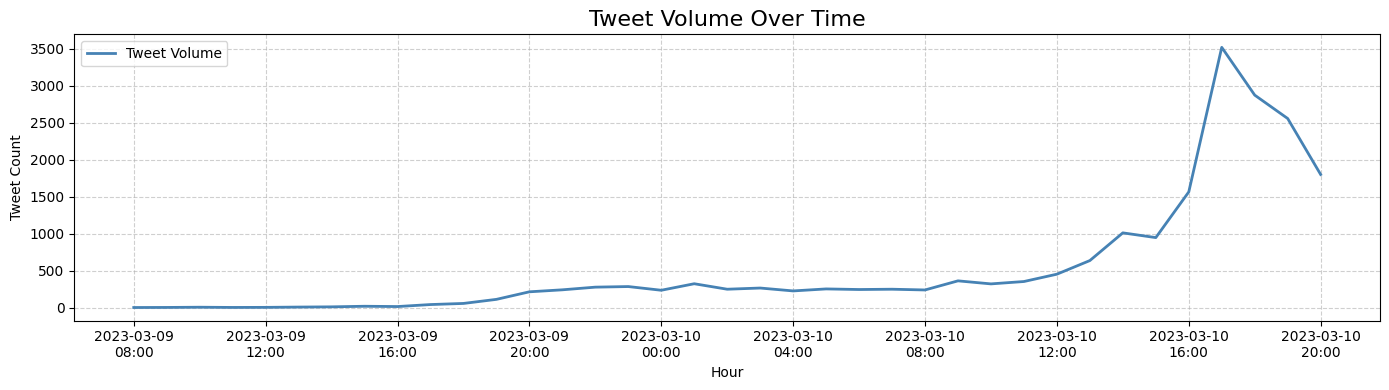

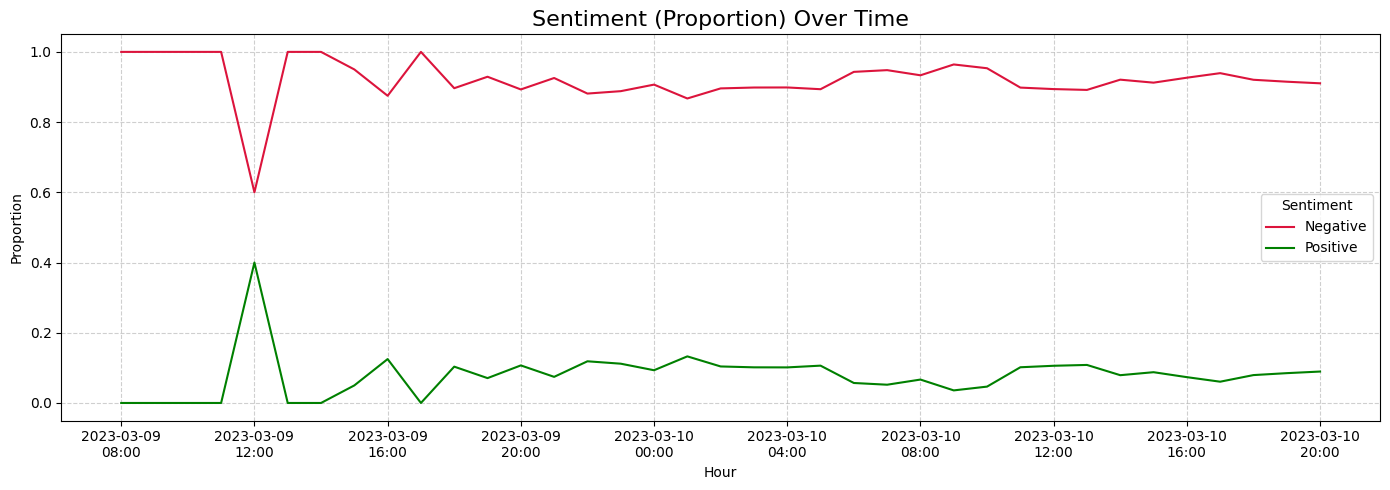

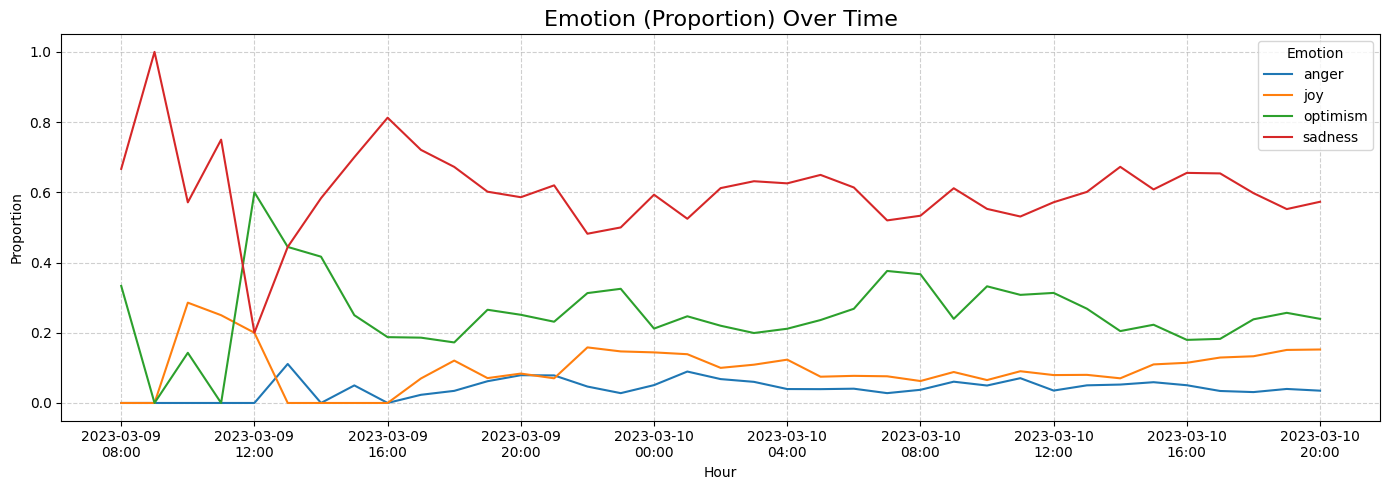

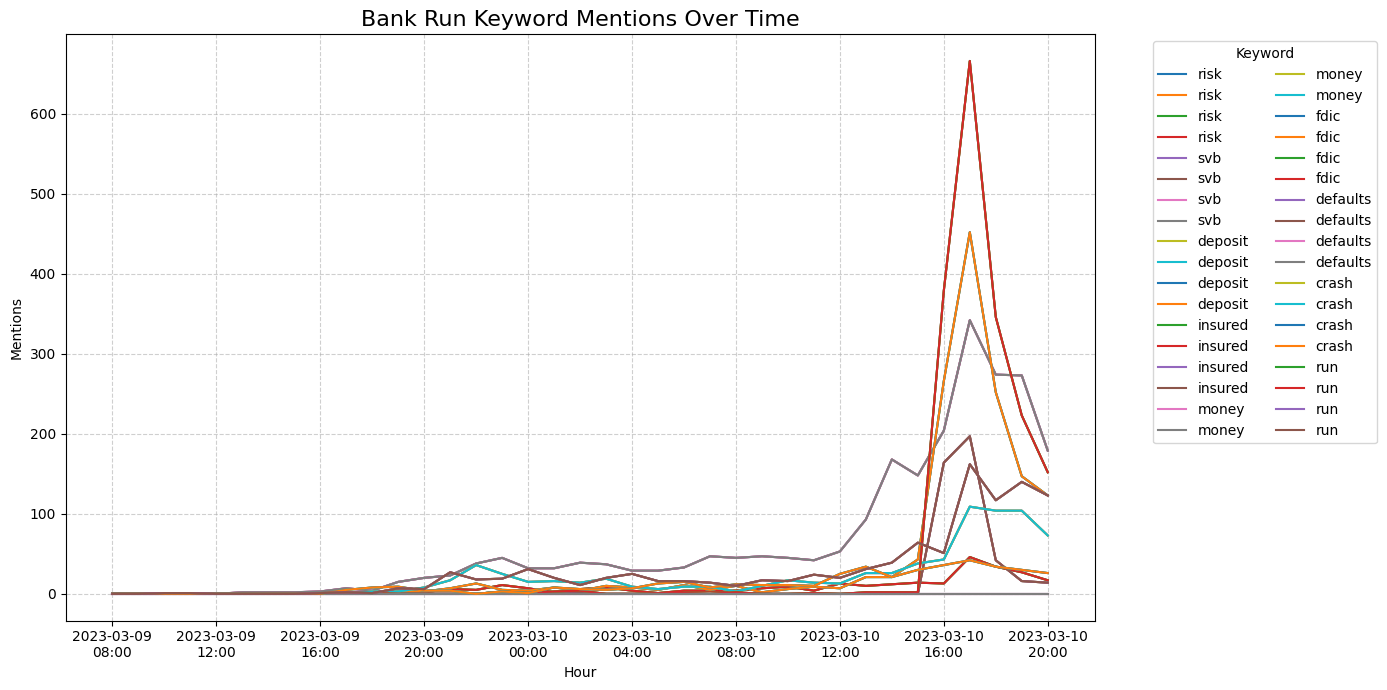

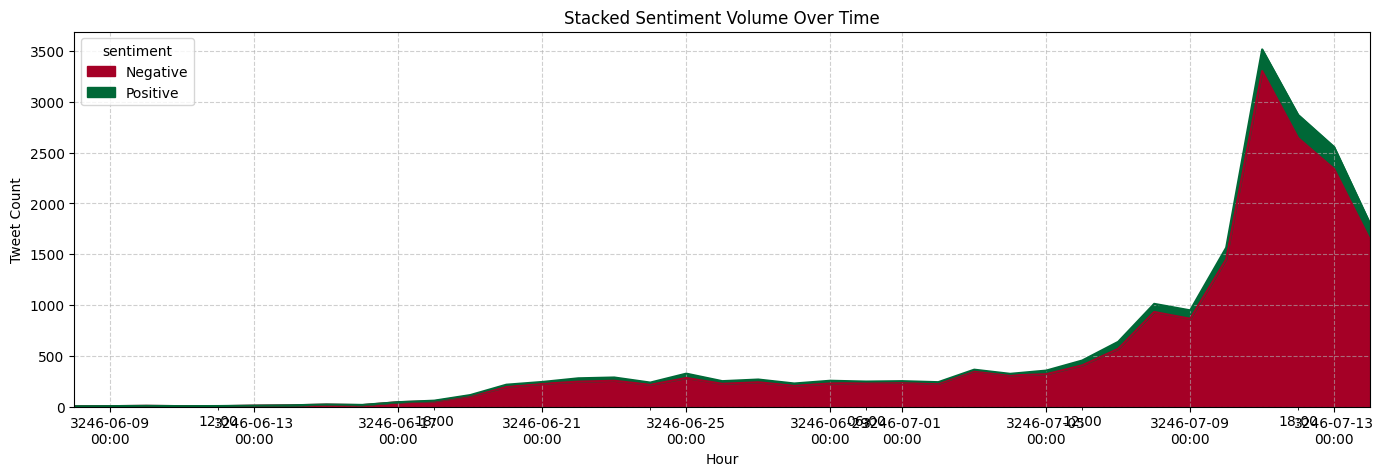

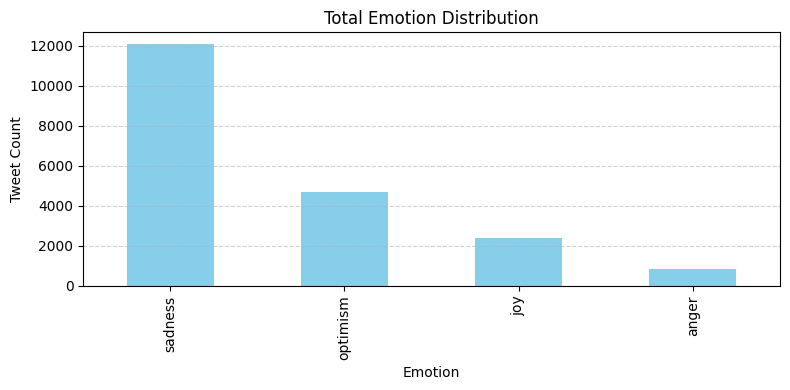

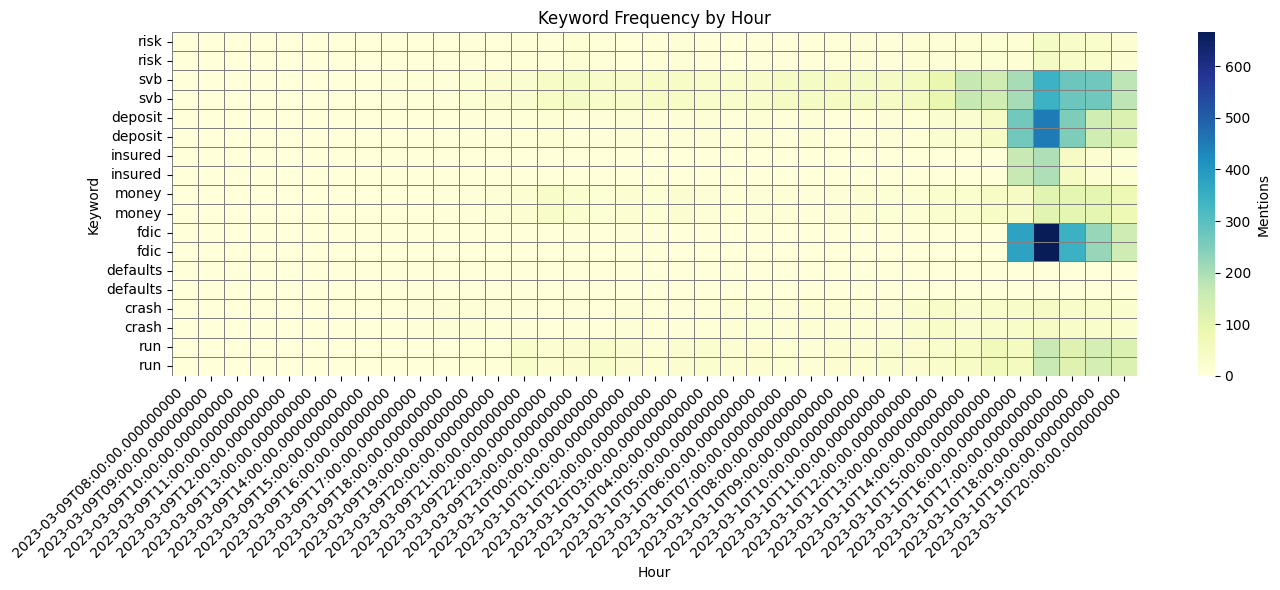

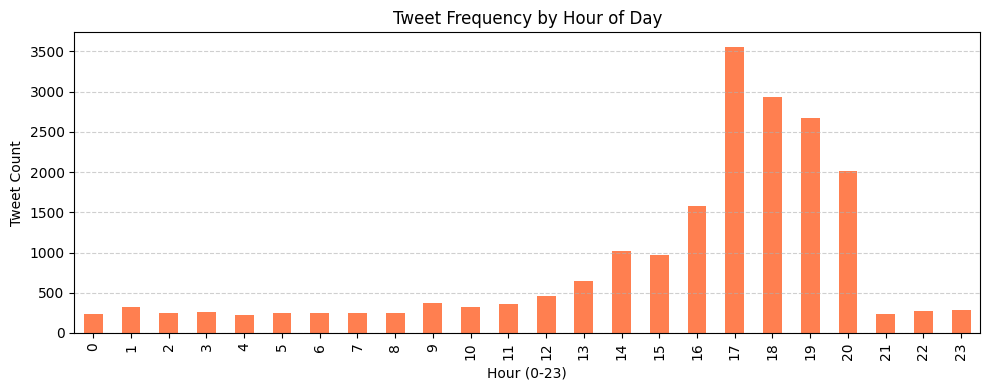

In [72]:
keywords = ['risk', 'svb', 'deposit', 'insured', 'money', 'fdic', 'defaults', 'crash', 'run']

def keyword_flags(text):
    words = set(text.split())
    return {kw: int(kw in words) for kw in keywords}

kw_df = df["clean_text"].apply(keyword_flags).apply(pd.Series)
df = pd.concat([df, kw_df], axis=1)

# Group by hour
df["hour"] = df["date"].dt.floor("h")

tweet_volume = df["hour"].value_counts().sort_index()
sentiment_by_hour = df.groupby("hour")["sentiment"].value_counts().unstack().fillna(0).sort_index()
emotion_by_hour = df.groupby("hour")["emotion"].value_counts().unstack().fillna(0).sort_index()
keyword_trends = df.groupby("hour")[keywords].sum()

# Convert counts to proportions
sentiment_percent = sentiment_by_hour.div(sentiment_by_hour.sum(axis=1), axis=0)
emotion_percent = emotion_by_hour.div(emotion_by_hour.sum(axis=1), axis=0)

# Plot formatting
date_fmt = mdates.DateFormatter('%Y-%m-%d\n%H:%M')
locator = mdates.AutoDateLocator()

# Tweet Volume Plot
plt.figure(figsize=(14, 4))
plt.plot(tweet_volume.index, tweet_volume.values, color="steelblue", linewidth=2, label="Tweet Volume")
plt.title("Tweet Volume Over Time", fontsize=16)
plt.xlabel("Hour"); plt.ylabel("Tweet Count")
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.gca().xaxis.set_major_locator(locator)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Sentiment Proportion Plot
plt.figure(figsize=(14, 5))
colors = {'Negative': 'crimson', 'Positive': 'green'}
for sentiment in sentiment_percent.columns:
    plt.plot(sentiment_percent.index, sentiment_percent[sentiment],
             label=sentiment, color=colors.get(sentiment, 'gray'))
plt.title("Sentiment (Proportion) Over Time", fontsize=16)
plt.xlabel("Hour"); plt.ylabel("Proportion")
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.gca().xaxis.set_major_locator(locator)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

# Emotion Proportion Plot
plt.figure(figsize=(14, 5))
for emotion in emotion_percent.columns:
    plt.plot(emotion_percent.index, emotion_percent[emotion], label=emotion)
plt.title("Emotion (Proportion) Over Time", fontsize=16)
plt.xlabel("Hour"); plt.ylabel("Proportion")
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.gca().xaxis.set_major_locator(locator)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Emotion")
plt.tight_layout()
plt.show()

# Keyword Mentions Plot
plt.figure(figsize=(14, 7))
for col in keyword_trends.columns:
    plt.plot(keyword_trends.index, keyword_trends[col], label=col)
plt.title("Bank Run Keyword Mentions Over Time", fontsize=16)
plt.xlabel("Hour"); plt.ylabel("Mentions")
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.gca().xaxis.set_major_locator(locator)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Keyword", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.tight_layout()
plt.show()

sentiment_by_hour.plot.area(stacked=True, figsize=(14, 5), colormap="RdYlGn")
plt.title("Stacked Sentiment Volume Over Time")
plt.xlabel("Hour"); plt.ylabel("Tweet Count")
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.gca().xaxis.set_major_locator(locator)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.subplots_adjust(bottom=0.15, top=0.90)
plt.show()


df["emotion"].value_counts().plot(kind="bar", color="skyblue", figsize=(8, 4))
plt.title("Total Emotion Distribution")
plt.xlabel("Emotion"); plt.ylabel("Tweet Count")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

import seaborn as sns
plt.figure(figsize=(14, 6))
sns.heatmap(
    keyword_trends.T,
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Mentions'},
    yticklabels=True  # Ensures keyword labels appear
)
plt.title("Keyword Frequency by Hour")
plt.xlabel("Hour")
plt.ylabel("Keyword")
plt.yticks(rotation=0, fontsize=10)  # Keep keywords horizontal and readable
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.tight_layout()
plt.show()

df["hour_of_day"] = df["date"].dt.hour
df["hour_of_day"].value_counts().sort_index().plot(kind="bar", figsize=(10, 4), color="coral")
plt.title("Tweet Frequency by Hour of Day")
plt.xlabel("Hour (0-23)"); plt.ylabel("Tweet Count")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

My analysis closely mirrors the approach used in the SSRN paper “Predicting Bank Runs with Social Media Sentiments”, but with several improvements and refinements. While the original study used cardiffnlp/twitter-roberta-base-sentiment and cardiffnlp/twitter-roberta-base-emotion, I opted for distilbert-base-uncased-finetuned-sst-2-english for sentiment offering faster predictions and a stronger emphasis on negative polarity and retained the Cardiff NLP emotion model. Instead of rolling averages, I aggregated sentiment, emotion, and keyword trends by hour, which gave me a clearer and more interpretable view of shifts over time. Like the paper, I observed a spike in tweet volume and a sharp rise in negative sentiment and sadness shortly before the SVB collapse, supporting the idea that social media reflects and may even escalate—bank run panic. I also included additional visualizations like emotion distributions and hourly activity patterns, which gave me deeper context. Overall, my results not only replicate the paper’s core findings but also enhance the interpretability and scope of the analysis.